# Email Classification building blocks

## Env set up

In [0]:
!python3 --version

Python 3.12.3


In [0]:
%pip install -U -qqqq langgraph langgraph-prebuilt langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai notebook langchain-tavily wikipedia trustcall langgraph-cli[inmem] transformers

%pip install -U -qqqq databricks-agents mlflow-skinny[databricks] databricks-langchain
dbutils.library.restartPython()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.20.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.19.5, but you have protobuf 6.33.3 which is incompatible.
grpcio-status 1.67.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.3 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-health-checking 1.76.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.5 which is incompatible.
grpcio-tools 1.75.1 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.5 which is incompatible.
langgraph-a

## Example data

In [0]:
## Creating a dataframe with examples
columns = ["id", "email_body"]
examples_ = [
  (1, "Dear sir or madam, I would like to get my residence address updated to: v. bella 1, Milano (MI), Italia"),

  (2, "Hello, I'd like to get an updated delivery date for shipment ID-45892171, given that I didn't receive it yet. Thank you"),

  (3, "Understood, I will wait a couple of days thanks"),

  (4, "Hi, the product arrived broken. I want a refund.")
]
df_example = spark.createDataFrame(examples_, columns)
display(df_example)

id,email_body
1,"Dear sir or madam, I would like to get my residence address updated to: v. bella 1, Milano (MI), Italia"
2,"Hello, I'd like to get an updated delivery date for shipment ID-45892171, given that I didn't receive it yet. Thank you"
3,"Understood, I will wait a couple of days thanks"
4,"Hi, the product arrived broken. I want a refund."


## Basic Architecture: single classifier node

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Graph State
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages, AnyMessage
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

## Set up the agent state to concatenate messages in memory
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    label: str
    rationale: str
    next_steps: str

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Output Schema
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

## Set up the output schema for the classification
from pydantic import BaseModel, Field
from typing import Literal

class LabelOutput(BaseModel):
  label: Literal[
      "Claim",
      "Profile Update",
      "Communication Unsubscription",
      "General Enquiry",
      "Spam",
      "Others"] = Field(
    description="Label assigned to the email",
    default="Others")
  rationale: str = Field(description="Reasoning behind the label choice")
  next_steps: str = Field(description="Recommended action items based on the customer's email")

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Base LLM
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from databricks_langchain import ChatDatabricks
model = ChatDatabricks(endpoint = "databricks-gpt-5-1", temperature=0) 

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Unexpected internal error when monkey patching `PreTrainedModel.from_pretrained`: 
PreTrainedModel requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.

Unexpected internal error when monkey patching `Trainer.train`: 
Trainer requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.



In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Classification Tool
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from langchain_core.tools import tool
from langgraph.graph import MessagesState

# Classify through prompt
MODEL_SYSTEM_MESSAGE = ("""
    You are an email dispatcher assistant.
    Based on some contextual information, your tasks are: 
        (1) assign a label to each customer's email.
        (2) provide an summarized explanation of why you assigned such label.
        (3) recommend next steps, based on the context.

    Here are the available labels you can choose from, together with a description of when to use them:
    - `Claim`: the customer is formally requesting a complaint or a refund.
    - `Profile Update`: the customer is requesting to update or modify their profile information (such as address, ...).
    - `Communication Unsubscription`: the customer is requesting to stop receiving communications or newsletter about products, offers, etc.
    - `General Enquiry`: the customer is asking for general information about their orders, the company, shipping policies, return policies, reimbursement terms, etc.
    - `Spam`: the email is suspected being a spam email, not referring to any plausible customer's request and is not a plausible follow up to previous requests.
    - `Others`: in case the email cannot be related to any of the previous labels.

    Here is the contextual information.

    The body email sent by the customer:
    <email_body>
    {email_body}
    </email_body>

    Now classify the email, explain your reasoning and recommend next steps.
""")

## Tool definition
def classify_email(state: AgentState) -> AgentState:
    
    """  Classify a customer email into one of the predefined labels, provide reasoning and next steps.  """
    
    # Extract email body from message list in the state
    email_body = state["messages"][-1].content
    
    # Pass data to the prompt
    full_prompt = MODEL_SYSTEM_MESSAGE.format(
        email_body=email_body,
    )

    # Invoke
    structured_model = model.with_structured_output(LabelOutput)
    result: LabelOutput = structured_model.invoke(
        [full_prompt] + state["messages"]
    )
    
    return {
        "messages": state["messages"] + [
            AIMessage(content = ("""
                Label: {Label}\n
                Rationale: {Rationale}\n
                Next steps: {NextSteps}
                """).format(Label=result.label, Rationale=result.rationale, NextSteps=result.next_steps))
        ],
        "label": result.label,
        "rationale": result.rationale,
        "next_steps": result.next_steps,
    }

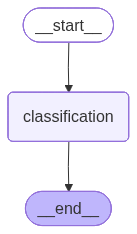

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Graph
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from langgraph. graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition # Check if the model's output is a tool call
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(AgentState)

# Nodes
builder.add_node("classification", classify_email)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "classification")
builder.add_edge("classification", END)
memory = MemorySaver()
react_email_classifier = builder.compile(checkpointer=memory)

display(Image(react_email_classifier.get_graph(xray=True).draw_mermaid_png()))

## Testing

In [0]:
## Testing
from pyspark.sql.functions import *
from langchain_core.messages import HumanMessage

# Extract test case from the dataframe with examples
config_ = {"configurable": {"thread_id": "1"}}
id_ = 4
example_row = df_example.filter(col("ID") == id_).first()
message_ = example_row.email_body

# Invoke the Agent
request = [
  HumanMessage(content = message_)
]
messages = react_email_classifier.invoke({"messages": request}, config_)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, I'd like to get an updated delivery date for shipment ID-45892171, given that I didn't receive it yet. Thank you
================================== Ai Message ==================================


                Label: General Enquiry

                Rationale: The customer is asking for an updated delivery date and status of a specific shipment, which is a request for order/shipping information rather than a complaint, refund, profile change, or unsubscription.

                Next steps: 1) Look up shipment ID-45892171 in the order/shipping management system. 2) Check current shipment status, latest tracking scan, and any carrier delays or exceptions. 3) Obtain the most accurate estimated delivery date from the carrier or internal system. 4) If the shipment appears lost or significantly delayed, follow internal escalation procedures (e.g., open an investigation with the carrier). 5) Reply to th